The code is adapted from https://mlabonne.github.io/blog/posts/2023-06-07-Decoding_strategies.html

In [146]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
} 
img {
    max-height: 500px;
}
</style>

In [147]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import numpy as np
import time
import ipympl
from tqdm.notebook import tqdm


def get_best_sequence(G):
    # Create a list of leaf nodes
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

    # Get the leaf node with the highest cumscore
    max_score_node = None
    max_score = float("-inf")
    for node in leaf_nodes:
        if G.nodes[node]["sequencescore"] > max_score:
            max_score = G.nodes[node]["sequencescore"]
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = "".join([G.nodes[node]["token"].split("_")[0] for node in path])

    return sequence, max_score


def plot_prob_distribution(
    tokenizer, probabilities, next_tokens, sampling, potential_nb, total_nb=50
):
    # Get top k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    # Get next tokens and their probabilities
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Create figure
    plt.figure(figsize=(0.4 * total_nb, 5), dpi=300, facecolor="white")
    plt.rc("axes", axisbelow=True)
    plt.grid(axis="y", linestyle="-", alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb - 0.5, ls=":", color="grey", label="Sampled tokens")
    plt.bar(top_k_tokens, top_k_prob.tolist(), color="blue")
    plt.bar(next_tokens_list, next_token_prob, color="red", label="Selected tokens")
    plt.xticks(rotation=45, ha="right", va="top")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    if sampling == "top_k":
        plt.title("Probability distribution of predicted tokens with top-k sampling")
    elif sampling == "nucleus":
        plt.title("Probability distribution of predicted tokens with nucleus sampling")
    plt.legend()
    plt.show()
    # plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    # plt.close()


def top_k_sampling(tokenizer, logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float("-inf")

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Sample n tokens from the resulting distribution
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(tokenizer, total_prob, next_tokens, "top_k", top_k)

    return next_tokens


def nucleus_sampling(tokenizer, logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    # Create a mask for probabilities that are in the top-p
    mask = cumulative_probabilities < p

    # If there's not n index where cumulative_probabilities < p, we use the top n tokens instead
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float("-inf")

    # Sample n tokens from the resulting distribution
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(
            tokenizer, total_prob, next_tokens, "nucleus", top_p_index_to_keep
        )

    return next_tokens


def beam_search(logits, beams):
    return torch.topk(logits, beams).indices


def decode(
    model,
    tokenizer,
    graph,
    input_ids,
    text,
    node,
    length,
    beams,
    sampling,
    bar,
    temperature=0.1,
    top_k=50,
    top_p=0.9,
):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == "beam_search":
        top_token_ids = beam_search(logits, beams)
    elif sampling == "top_k":
        top_token_ids = top_k_sampling(tokenizer, logits, temperature, top_k, beams)
    elif sampling == "top_p":
        top_token_ids = nucleus_sampling(tokenizer, logits, temperature, top_p, beams)
    else:
        raise ValueError(f"Sampling method {sampling} not supported")

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Compute the score of the predicted token
        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]["cumscore"] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat(
            [input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1
        )

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]["tokenscore"] = np.exp(token_score) * 100
        graph.nodes[current_node]["cumscore"] = cumulative_score
        graph.nodes[current_node]["sequencescore"] = (
            1 / (len(new_input_ids.squeeze())) * cumulative_score
        )
        graph.nodes[current_node]["token"] = token + f"_{length}_{j}"

        # Recursive call
        decode(
            model=model,
            tokenizer=tokenizer,
            graph=graph,
            input_ids=new_input_ids,
            text=text,
            node=current_node,
            length=length - 1,
            beams=beams,
            sampling=sampling,
            bar=bar,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
        )


def run_decoding(
    model,
    tokenizer,
    input_ids,
    text,
    length,
    decoding_algorithm,
    beams=1,
    temperature=0.1,
    top_k=50,
    top_p=0.9,
):
    graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
    bar = tqdm(total=len(graph.nodes))
    bar.colour = "#1f77b4"

    # Add 'tokenscore', 'cumscore', and 'token' attributes to each node
    for node in graph.nodes:
        graph.nodes[node]["tokenscore"] = 100
        graph.nodes[node]["cumscore"] = 0
        graph.nodes[node]["sequencescore"] = 0
        graph.nodes[node]["token"] = text

    # Call the recursive function
    decode(
        model=model,
        tokenizer=tokenizer,
        graph=graph,
        input_ids=input_ids,
        text=text,
        node=0,
        length=length,
        beams=beams,
        sampling=decoding_algorithm,
        bar=bar,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
    )

    return graph


def get_log_prob(logits, token_id):
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability


def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(
        figsize=(3 + 1.2 * beams**length, max(5, 2 + length)),
        dpi=300,
        facecolor="white",
    )

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == "token":
        scores = [
            data["tokenscore"]
            for _, data in graph.nodes(data=True)
            if data["token"] is not None
        ]
    elif score == "sequence":
        scores = [
            data["sequencescore"]
            for _, data in graph.nodes(data=True)
            if data["token"] is not None
        ]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)
    # cmap = "turbo"
    
    # Draw the nodes
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=2000,
        node_shape="o",
        alpha=1,
        linewidths=4,
        node_color=scores,
        cmap=cmap,
    )

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == "token":
        labels = {
            node: data["token"].split("_")[0] + f"\n{data['tokenscore']:.2f}%"
            for node, data in graph.nodes(data=True)
            if data["token"] is not None
        }
    elif score == "sequence":
        labels = {
            node: data["token"].split("_")[0] + f"\n{data['sequencescore']:.2f}"
            for node, data in graph.nodes(data=True)
            if data["token"] is not None
        }
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == "token":
        fig.colorbar(
            sm, ax=ax, orientation="vertical", pad=0, label="Token probability (%)"
        )
    elif score == "sequence":
        fig.colorbar(sm, ax=ax, orientation="vertical", pad=0, label="Sequence score")
    # plt.savefig(f"output.pdf")

    plt.show()

In [148]:
%%capture
# model loading

device = "cuda"
model_name = 'gpt2'

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

  0%|          | 0/4 [00:00<?, ?it/s]

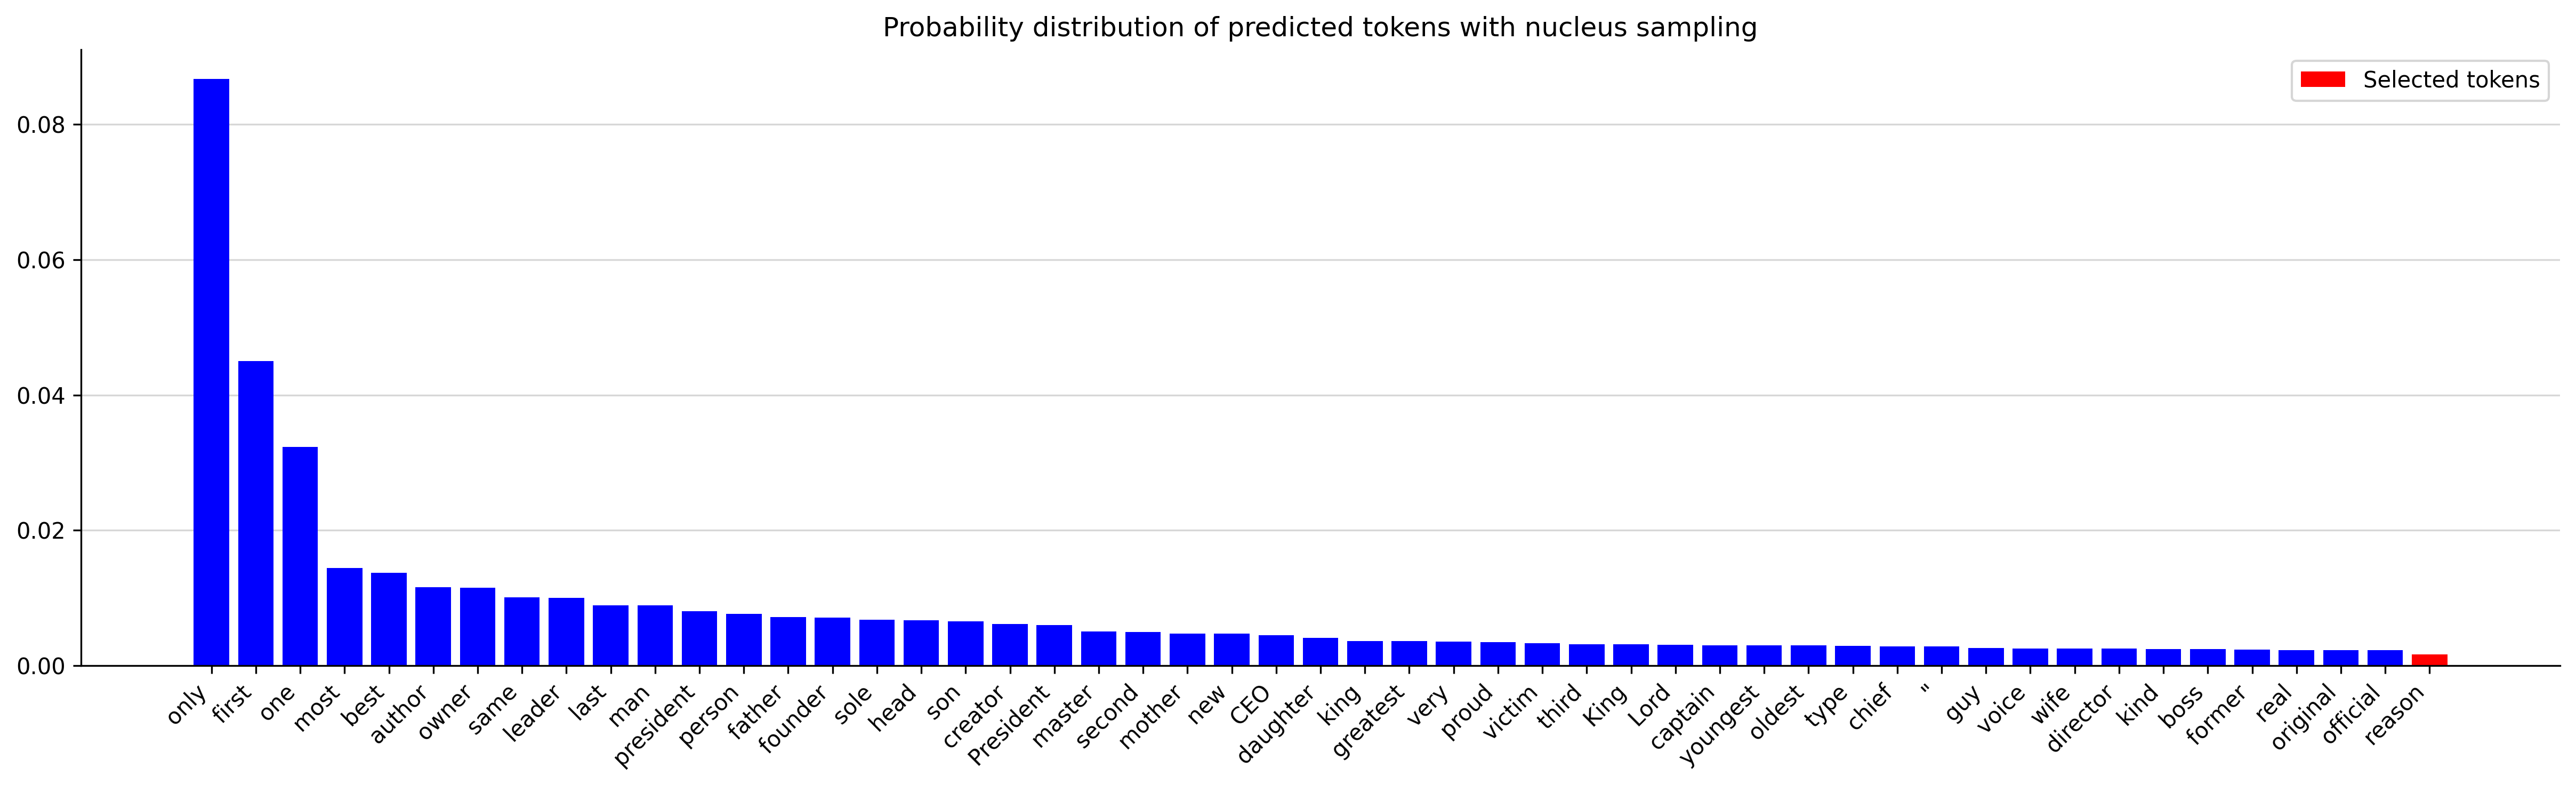

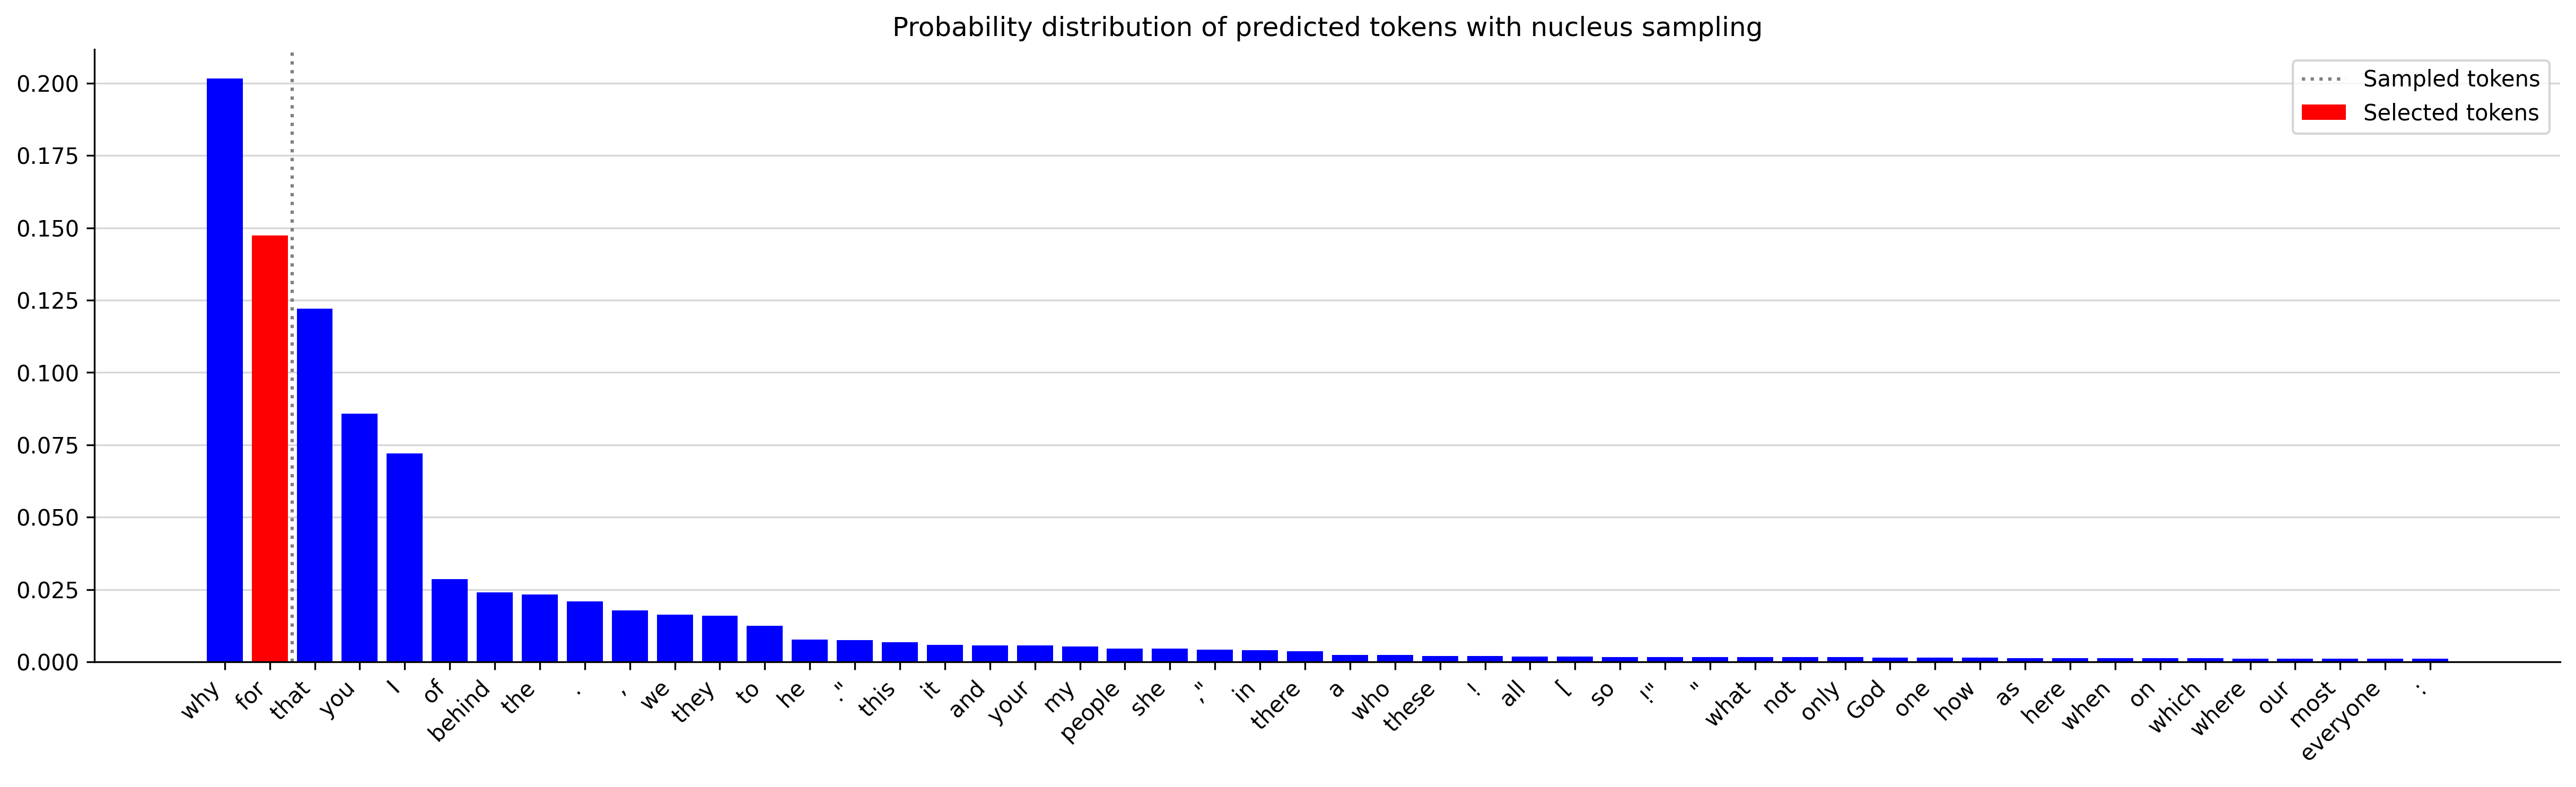

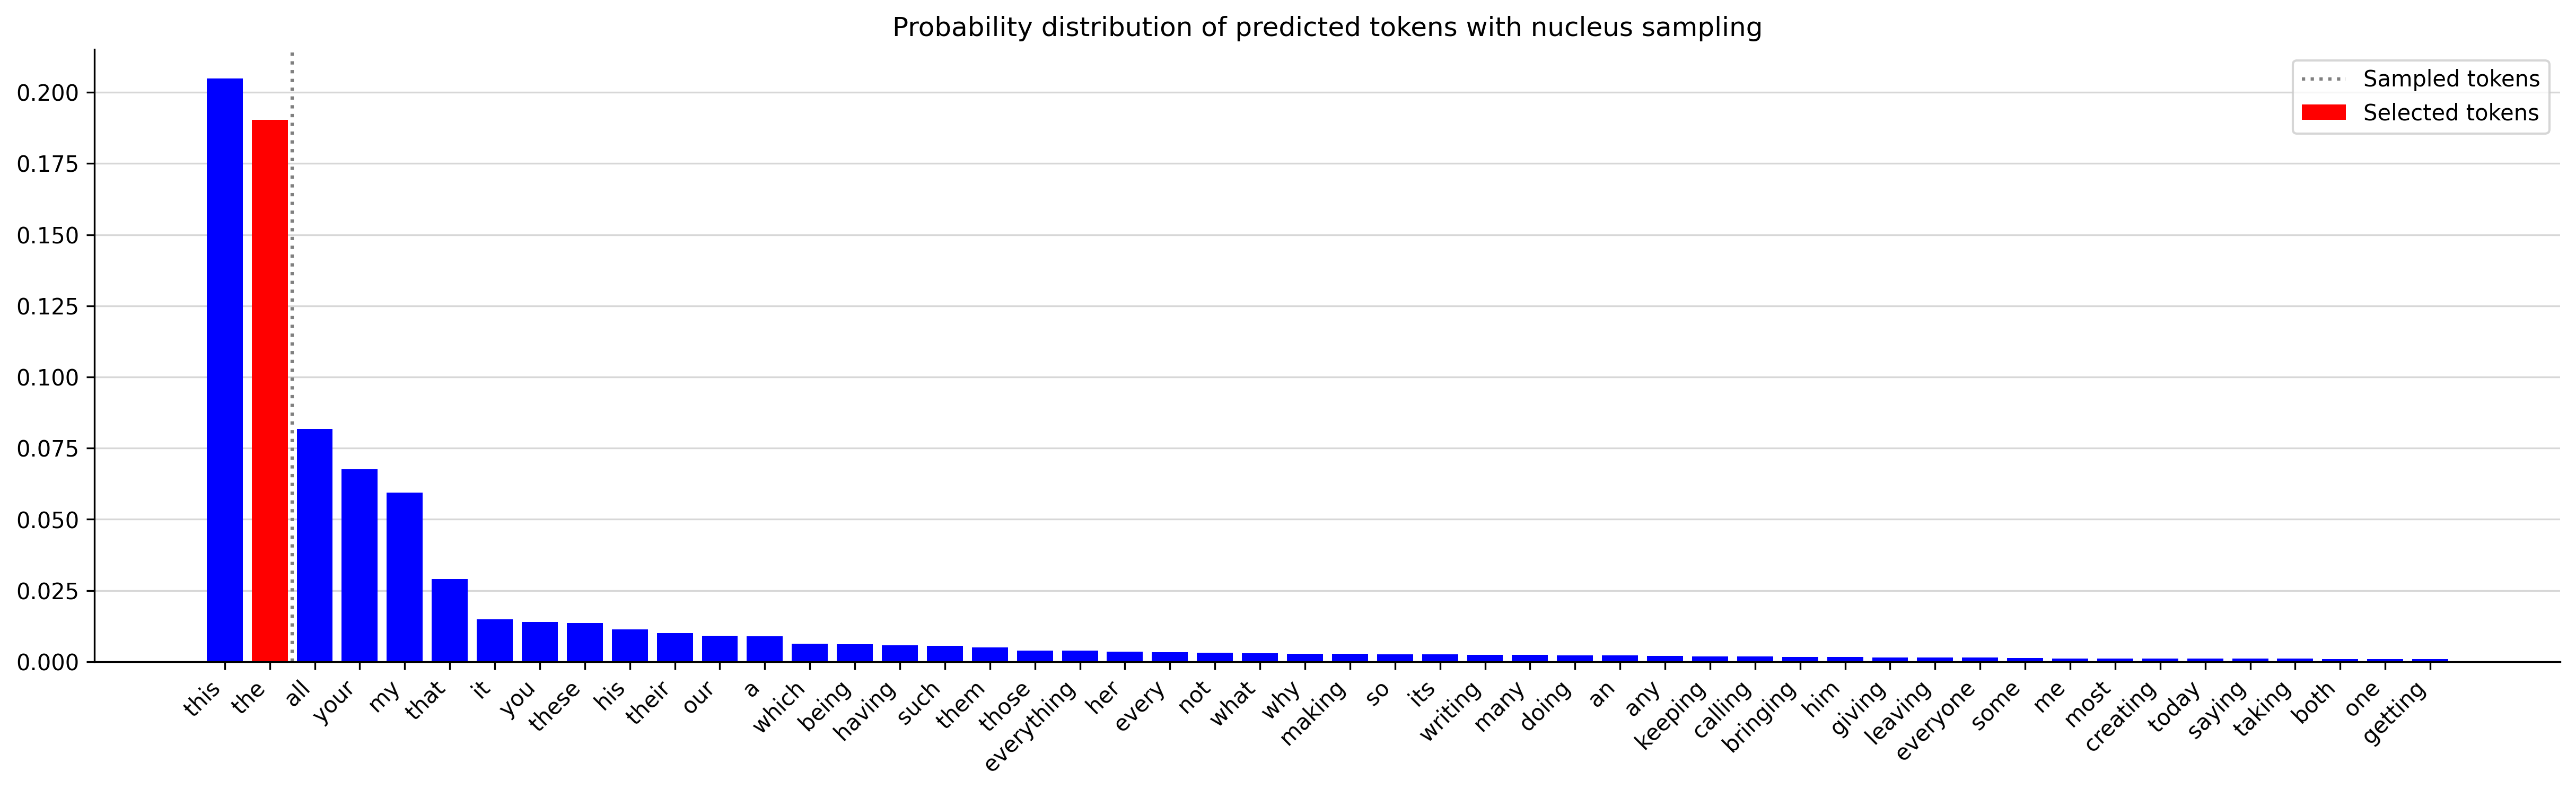

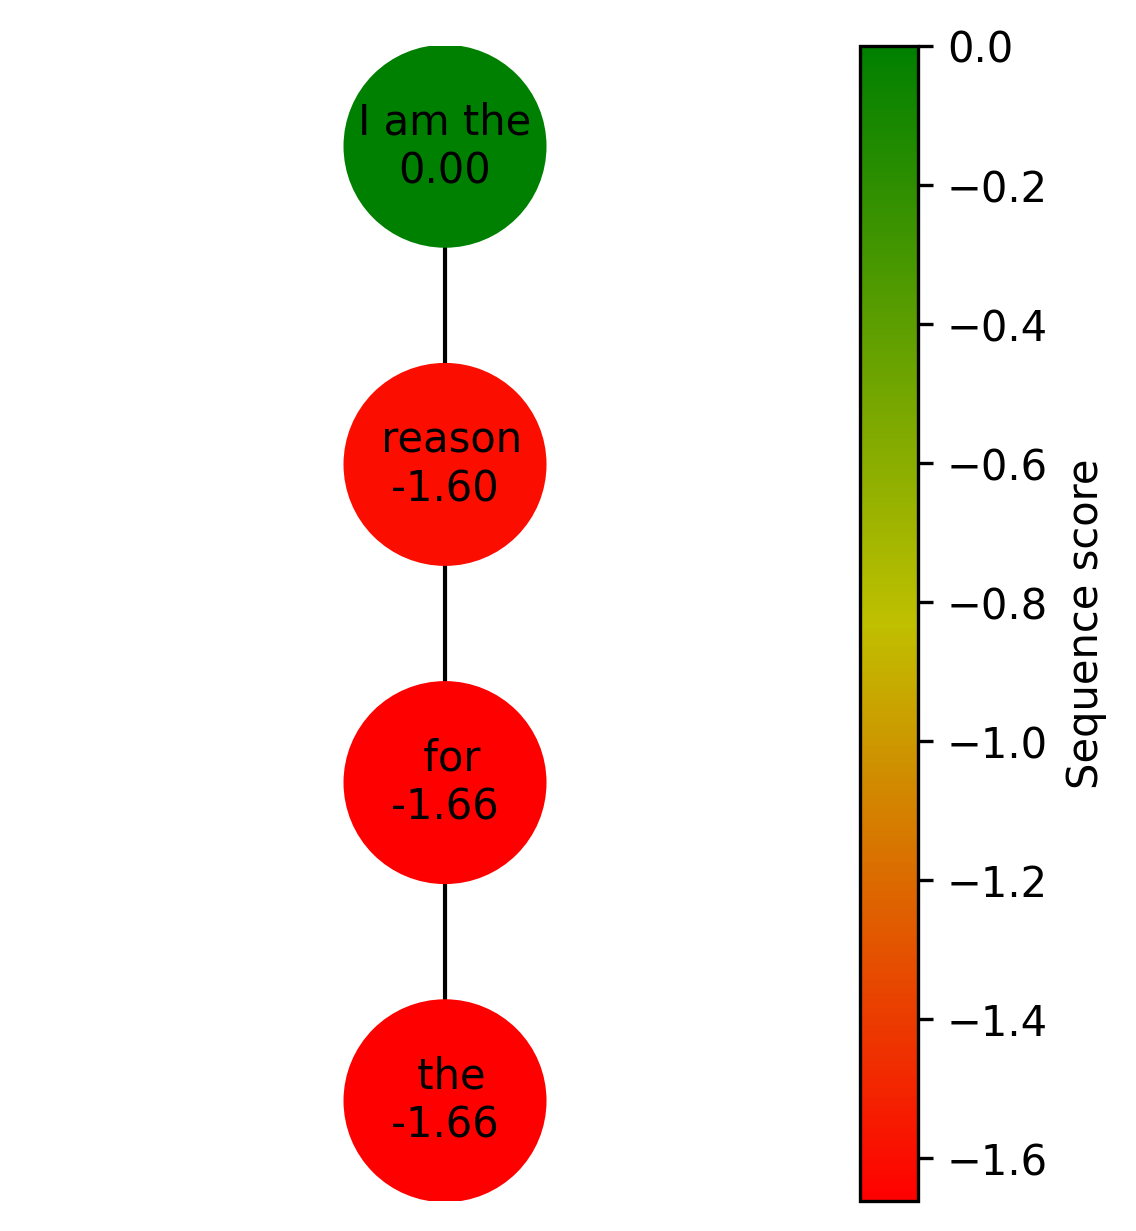

Generated text: I am the reason for the


In [174]:
%matplotlib inline

decoding_algorithm = 'top_p'
length = 3
beams = 1
temperature = 1.0
# top_k = 5
top_p = 0.5

# input
text = "I am the"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

# decode
graph = run_decoding(
    model=model, 
    tokenizer=tokenizer, 
    input_ids=input_ids, 
    text=text,
    length=length, 
    beams=beams, 
    decoding_algorithm=decoding_algorithm, 
    temperature=temperature,
    # top_k=top_k,
    top_p=top_p
)

sequence, max_score = get_best_sequence(graph)
plot_graph(graph, length, beams, 'sequence')

print(f"Generated text: {sequence}")


